In [1]:
%reset -f
import cv2
import matplotlib.pyplot as plt
import numpy as np
import sys
import os
import glob

%matplotlib inline
%pylab inline
pylab.rcParams['figure.figsize'] = (20, 12)

Populating the interactive namespace from numpy and matplotlib


In [45]:
def getSobel (channel):

    sobelx = cv2.Sobel(channel, cv2.CV_16S, 1, 0, borderType=cv2.BORDER_REPLICATE)
    sobely = cv2.Sobel(channel, cv2.CV_16S, 0, 1, borderType=cv2.BORDER_REPLICATE)
    sobel = np.hypot(sobelx, sobely)

    return sobel;

def findSignificantContours (img, sobel_8u):
    image, contours, heirarchy = cv2.findContours(sobel_8u, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    # Find level 1 contours
    level1 = []
    for i, tupl in enumerate(heirarchy[0]):
        # Each array is in format (Next, Prev, First child, Parent)
        # Filter the ones without parent
        if tupl[3] == -1:
            tupl = np.insert(tupl, 0, [i])
            level1.append(tupl)

    # From among them, find the contours with large surface area.
    significant = []
    tooSmall = sobel_8u.size * 30 / 100 # If contour isn't covering 5% of total area of image then it probably is too small
    for tupl in level1:
        contour = contours[tupl[0]];
        area = cv2.contourArea(contour)
        if area > tooSmall:
            cv2.drawContours(img, [contour], 0, (0,255,0),2, cv2.LINE_AA, maxLevel=1)
            significant.append([contour, area])

    significant.sort(key=lambda x: x[1])
    return [x[0] for x in significant];

def segment (input):
    img = cv2.imread(input)

    blurred = cv2.GaussianBlur(img, (5, 5), 0) # Remove noise

    # Edge operator
    sobel = np.max(np.array([getSobel(blurred[:,:, 0]), getSobel(blurred[:,:, 1]), getSobel(blurred[:,:, 2]) ]), axis=0 )

    # Noise reduction trick, from http://sourceforge.net/p/octave/image/ci/default/tree/inst/edge.m#l182
    mean = np.mean(sobel)

    # Zero any values less than mean. This reduces a lot of noise.
    sobel[sobel <= mean] = 0;
    sobel[sobel > 255] = 255;

    #cv2.imwrite('output/edge.png', sobel);
    sobel_8u = np.asarray(sobel, np.uint8)

    # Find contours
    significant = findSignificantContours(img, sobel_8u)

    # Mask
    mask = sobel.copy()
    mask[mask > 0] = 0
    cv2.fillPoly(mask, significant, 255)
    # Invert mask
    mask = np.logical_not(mask)

    #Finally remove the background
    img[mask] = 0
    return img, sobel


In [46]:
files = glob.glob("Images/*.tif")[:1]
files

['Images/ID0036.tif']

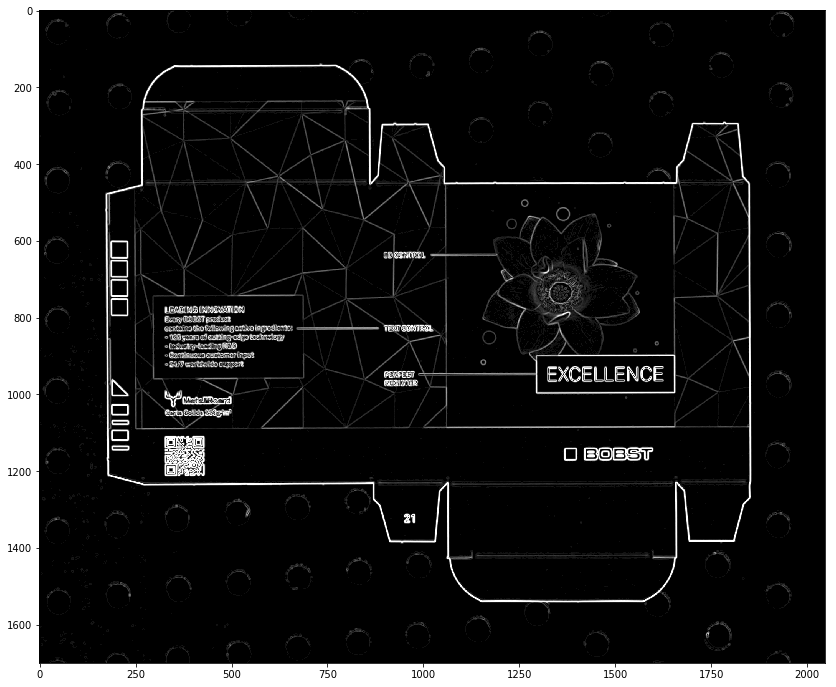

In [48]:
# for input in files:
input = files[0]
result, sobel = segment(input)
plt.imshow(cv2.cvtColor(result, cv2.COLOR_BGR2RGB))

In [ ]:
plt.imshow(r2, cmap="gray")